# PROJECT-3. EDA + Feature Engineering. Соревнование на Kaggle

## 0. Описание кейса и постановка задачи

Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, *которая предсказывает рейтинг отеля*. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

Вы будете работать с датасетом, в котором содержатся сведения о 515 000 отзывов на отели Европы. Модель, которую вы будете обучать, должна предсказывать рейтинг отеля по данным сайта Booking на основе имеющихся в датасете данных. Изученные нами навыки разведывательного анализа помогут улучшить модель.

Первоначальная версия датасета содержит 17 полей со следующей информацией:

- hotel_address — адрес отеля;
- review_date — дата, когда рецензент разместил соответствующий отзыв;
- average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
- hotel_name — название отеля;
- reviewer_nationality — страна рецензента;
- negative_review — отрицательный отзыв, который рецензент дал отелю;
- review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
- positive_review — положительный отзыв, который рецензент дал отелю;
- review_total_positive_word_counts — общее количество слов в положительном отзыве.
- reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
- total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
- total_number_of_reviews — общее количество действительных отзывов об отеле;
- tags — теги, которые рецензент дал отелю;
- days_since_review — количество дней между датой проверки и датой очистки;
- additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
- lat — географическая широта отеля;
- lng — географическая долгота отеля.

## 1. Подготовка к работе

### 1.1. Импорт библиотек

In [113]:
import pandas as pd
import numpy as np

# Загружаем специальный инструмент для разбивки данных:  
from sklearn.model_selection import train_test_split

# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
# инструменты для оценки точности модели
from sklearn import metrics

# библиотека для логирования эксперимента
from comet_ml import Experiment

# Библиотеки визуализации
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Установка параметров визуализации
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
sns.set_theme(style='darkgrid')

### 1.1. Собственные функции

TODO: Перенести в отдельный модуль

Функция построения графиков распределения

In [2]:
def box_hist_plot(data: pd.DataFrame, x: str, title: str, hist_kde=False, hist_yscale='linear', box_showmeans=True, height_ratios=(.15, .85)) -> matplotlib.figure.Figure:
    """Plot Seaborn boxplot and histplot one above the other

    Args:
        data (pd.DataFrame): Data for plotting
        x (str): Columns name for plotting
        title (str): Figure (plot) name
        hist_kde (bool): If True, compute a Kernel Density Estimate. Defaults to False.
        hist_yscale (str): Hist count axis Scale. Defaults to 'linear'.
        box_showmeans (bool): Show mean-value point with the marker. Defaults to True.
        height_ratios (tuple): Height ratios of the boxplot and histplot. Defaults to (.15, .85).

    Returns:
        matplotlib.figure.Figure: Figure with seaborn boxplot and hitstplot
    """
    # Create a figure composed of two axes objects
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
        gridspec_kw={
            'height_ratios': height_ratios
    })
    # Set up figure
    f.suptitle(title);
    f.tight_layout()

    # Plot boxplot
    sns.boxplot(data=data, x=x, showmeans=box_showmeans, 
                meanprops={"marker":"1",
                        "markeredgecolor":"white",
                        "markersize":"10"}, 
                ax=ax_box)
    ax_box.set(xlabel=None)

    # Plot histplot
    sns.histplot(data=data, x=x, kde=hist_kde, ax=ax_hist)
    ax_hist.set_yscale(hist_yscale)
    plt.close(f)    
    # Return figure
    return f

### 1.2. Запуск эксперимента

In [3]:
# experiment = Experiment(
#     api_key='3gDYBYgwtqbTbf3z0fBLFin1U',
#     project_name='booking-reviews',
#     workspace='mvulf'
# )

### 1.3. Константы обучения

In [4]:
TEST_SIZE = 0.25
RANDOM_STATE = 42
N_ESTIMATORS = 100
TARGET_NAME = 'reviewer_score'

if 'experiment' in locals():
    # Логируем применяемые параметры
    params = {
        'test_size': TEST_SIZE,
        'random_state': RANDOM_STATE,
        'n_estimators': N_ESTIMATORS,
        'target_name': TARGET_NAME
    }
    experiment.log_parameters(params)

### 1.4. Загрузка данных

In [5]:
# Загрузим данные с переводом строки-списка в список
hotels = pd.read_csv('input/hotels.csv')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


## 2. Понимание данных

In [6]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

Явные пропуски содержатся в колонках долготы и широты местоположения отеля (lat & lng).
В числовом формате данные хранятся в 9 из 16 столбцах.

#### **hotel_address** и **hotel_name**

Оценим количество отелей в данных

In [7]:
print(f"Количество уникальных адресов отелей: {hotels['hotel_address'].nunique()}")
print(f"Количество уникальных имён отелей: {hotels['hotel_name'].nunique()}")

Количество уникальных адресов отелей: 1493
Количество уникальных имён отелей: 1492


Похоже, что на одно название отеля приходится 2 адреса. Определим, что это за отель.

In [8]:
# Сгруппируем по именам отелей и определим уникальные адреса
hotels_addresses = hotels.groupby(by='hotel_name')['hotel_address'].nunique()
# Проанализируем количество уникальных адресов для каждого отеля
n_hotels_addresses = hotels_addresses.sort_values(ascending=False)
n_hotels_addresses

hotel_name
Hotel Regina                                    3
11 Cadogan Gardens                              1
Mercure Paris Gare Montparnasse                 1
Mercure Paris Pigalle Sacre Coeur               1
Mercure Paris Opera Louvre                      1
                                               ..
Ham Yard Hotel                                  1
Hallmark Hotel London Chigwell Prince Regent    1
HCC St Moritz                                   1
HCC Regente                                     1
pentahotel Vienna                               1
Name: hotel_address, Length: 1492, dtype: int64

Таким образом, мы видим, что только у "Hotel Regina" имеется несколько уникальных адресов. Посмотрим на эти адреса

In [9]:
# Извлечём название отеля с несколькими адресами
frequent_hotel = n_hotels_addresses.index[0]

# Проанализируем адреса этого отеля
frequent_hotel_addresses = list(hotels[hotels['hotel_name'] == frequent_hotel]['hotel_address'].unique())
print(f'Адреса отеля {frequent_hotel}: {frequent_hotel_addresses}')

Адреса отеля Hotel Regina: ['Bergara 2 4 Eixample 08002 Barcelona Spain', 'Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria', 'Via Cesare Correnti 13 Milan City Center 20123 Milan Italy']


У "Hotel Regina" есть 3 адреса в различных странах: Испания, Италия и Австрия.

При этом число уникальных названий отелей и уникальных адресов отличается только на 1 в пользу адреса. Можно предположить, что есть дублирование адреса. Проверим.

In [10]:
# Сгруппируем по адресам отелей и определим уникальные имена
hotels_names = hotels.groupby(by='hotel_address')['hotel_name'].nunique()
# Проанализируем количество уникальных имён для каждого адреса
n_hotels_names = hotels_names.sort_values(ascending=False)
n_hotels_names.head(5)

hotel_address
8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom    2
Hernalser Hauptstra e 105 17 Hernals 1170 Vienna Austria                      1
Hoffingergasse 26 28 12 Meidling 1120 Vienna Austria                          1
Hobbemakade 50 Oud Zuid 1071 XL Amsterdam Netherlands                         1
Hintschiggasse 1 10 Favoriten 1100 Vienna Austria                             1
Name: hotel_name, dtype: int64

Таким образом, есть адрес, по которому зарегистрировано 2 отеля. Посмотрим на названия отелей.

In [11]:
# Извлечём адрес с несколькими отелями
frequent_address = n_hotels_names.index[0]

# Проанализируем отели одного адреса
frequent_address_hotels = list(hotels[hotels['hotel_address'] == frequent_address]['hotel_name'].unique())
print(f'Названия отелей по адресу {frequent_address}: {frequent_address_hotels}')

Названия отелей по адресу 8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom: ['The Grand at Trafalgar Square', 'Club Quarters Hotel Trafalgar Square']


Проверка с помощью онлайн-карт google подтвердила, что по одному адресу зарегистрированы 2 отеля.

Посмотрим на частоту отзывов отелей:

In [12]:
display(hotels.groupby(by=['hotel_name','hotel_address'])['review_date'].count().sort_values(ascending=True).reset_index().head(1200))
display(hotels.groupby(by=['hotel_name','hotel_address'])['review_date'].count().sort_values(ascending=False).reset_index().head(300))

,hotel_name,hotel_address,review_date
0,Mercure Paris Porte d Orleans,13 Rue Fran ois Ory 92120 Paris France,5
1,Hotel Wagner,Via M Buonarroti 13 Fiera Milano City 20149 Mi...,6
2,Hotel Gallitzinberg,Johann Staud Stra e 32 16 Ottakring 1160 Vienn...,6
3,Renaissance Paris Republique Hotel Spa,40 Rue Rene Boulanger 10th arr 75010 Paris France,7
4,Ibis Styles Milano Palmanova,Via Palmanova 153 20132 Milan Italy,7
...,...,...,...
1195,LaGare Hotel Milano Centrale MGallery by Sofitel,Via Gian Battista Pirelli 20 Central Station 2...,381
1196,Park International Hotel,117 129 Cromwell Road Kensington and Chelsea L...,382
1197,H10 Metropolitan 4 Sup,Rambla Catalunya 7 9 Eixample 08007 Barcelona ...,382
1198,Novotel Paris Les Halles,8 Place Marguerite de Navarre 1st arr 75001 Pa...,383


,hotel_name,hotel_address,review_date
0,Britannia International Hotel Canary Wharf,163 Marsh Wall Docklands Tower Hamlets London ...,3587
1,Strand Palace Hotel,372 Strand Westminster Borough London WC2R 0JJ...,3206
2,Park Plaza Westminster Bridge London,Westminster Bridge Road Lambeth London SE1 7UT...,3095
3,Copthorne Tara Hotel London Kensington,Scarsdale Place Kensington Kensington and Chel...,2688
4,DoubleTree by Hilton Hotel London Tower of London,7 Pepys Street City of London London EC3N 4AF ...,2379
...,...,...,...
295,Great St Helen Hotel,36 Great st Helens City of London London EC3A ...,383
296,Park International Hotel,117 129 Cromwell Road Kensington and Chelsea L...,382
297,H10 Metropolitan 4 Sup,Rambla Catalunya 7 9 Eixample 08007 Barcelona ...,382
298,Catalonia Passeig de Gr cia 4 Sup,Gran Via de les Corts Catalanes 644 Eixample 0...,381


**Note**: 
- В дальнейшем может потребоваться уменьшить количество уникальных названий отеля, введя категорию other_name для остальных названий. *Например, при сокращении до 300 уникальных имён отелей по количеству отзывов.*
- При необходимости, к имени 'Hotel Regina' можно добавить страну расположения отеля.
- При генерации признаков из полного адреса можно извлечь город и страну расположения отеля.

#### **additional_number_of_scoring**

Согласно представленному выше описанию получается, что это общее количество оценок без отзывов, которое выставлено отелю. Значит у разных отзывов одного отеля должны быть одинаковые значения. Проверим это.

In [13]:
grouped_by_name = hotels.groupby(by='hotel_name')
scoring_number_difference = grouped_by_name['additional_number_of_scoring'].max() - grouped_by_name['additional_number_of_scoring'].min()
scoring_number_difference.sort_values(ascending=False)

hotel_name
Hotel Regina                                    311
11 Cadogan Gardens                                0
Mercure Paris Gare Montparnasse                   0
Mercure Paris Pigalle Sacre Coeur                 0
Mercure Paris Opera Louvre                        0
                                               ... 
Ham Yard Hotel                                    0
Hallmark Hotel London Chigwell Prince Regent      0
HCC St Moritz                                     0
HCC Regente                                       0
pentahotel Vienna                                 0
Name: additional_number_of_scoring, Length: 1492, dtype: int64

Видим, что разница в количестве отзывов есть только у отеля Регина. Проверим, что для трёх отелей разных адресов три разные цифры количества оценок, и при этом они не отличаются в рамках одного адреса

In [14]:
regina_grouped_by_name = hotels[hotels['hotel_name'] == 'Hotel Regina'].groupby('hotel_address')

regina_median_scoring_number = regina_grouped_by_name['additional_number_of_scoring'].median()
print('Количество оценок без отзывов для отеля Регина по разным адресам')
display(regina_median_scoring_number.sort_values(ascending=False))

regina_scoring_number_difference = regina_grouped_by_name['additional_number_of_scoring'].max() - regina_grouped_by_name['additional_number_of_scoring'].min()
print('Разница в количестве оценок в рамках одного адреса')
display(regina_scoring_number_difference.sort_values(ascending=False))

Количество оценок без отзывов для отеля Регина по разным адресам


hotel_address
Bergara 2 4 Eixample 08002 Barcelona Spain                    334.0
Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria           165.0
Via Cesare Correnti 13 Milan City Center 20123 Milan Italy     23.0
Name: additional_number_of_scoring, dtype: float64

Разница в количестве оценок в рамках одного адреса


hotel_address
Bergara 2 4 Eixample 08002 Barcelona Spain                    0
Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria           0
Via Cesare Correnti 13 Milan City Center 20123 Milan Italy    0
Name: additional_number_of_scoring, dtype: int64

**Note**: Таким образом, мы убедились в том, что статистика для Отелей Регина разных стран ведётся отдельно.

#### **review_date**

Приведём к формату datetime

In [15]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['review_date'].describe(datetime_is_numeric=True)

count                           386803
mean     2016-08-13 14:41:18.712936704
min                2015-08-04 00:00:00
25%                2016-02-23 00:00:00
50%                2016-08-15 00:00:00
75%                2017-02-09 00:00:00
max                2017-08-03 00:00:00
Name: review_date, dtype: object

Таким образом, перед нами выгрузка отзывов за 2 года с 4 августа 2015 года по 3 августа 2017 года.

**Note:**
- В дальнейшем из даты можно извлечь сезонность

#### **average_score**

Данный признак представляет собой среднюю оценку отеля за последний год. Проанализируем его

count    386803.000000
mean          8.397231
std           0.547881
min           5.200000
25%           8.100000
50%           8.400000
75%           8.800000
max           9.800000
Name: average_score, dtype: float64

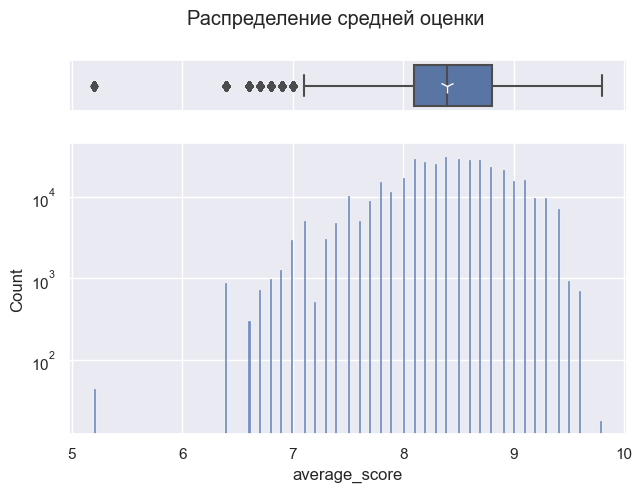

In [81]:
average_score_plot = box_hist_plot(hotels, 'average_score', 'Распределение средней оценки', hist_yscale='log')
display(hotels['average_score'].describe())
average_score_plot

Наблюдаем левосторонние гипотетические выбросы, а также отели с очень высокой оценкой

Оценим визуально взаимосвязь средней оценки и оценки в отзыве

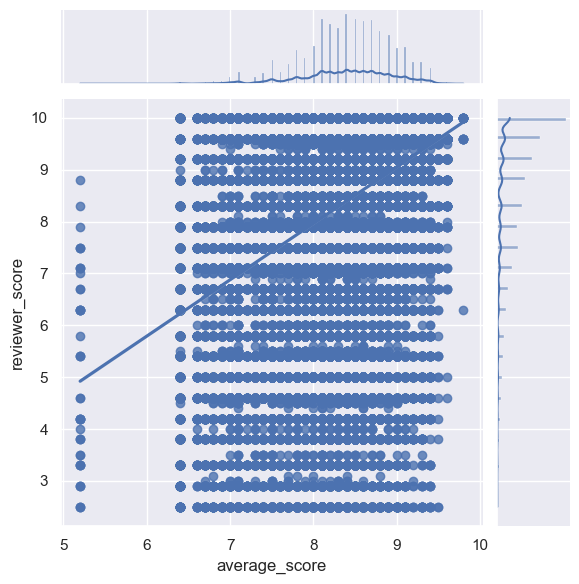

In [97]:
sns.jointplot(y='reviewer_score', x='average_score', data=hotels, kind='reg')

**Note**:
- Имеет смысл ввести порядковый категориальный признак, чтобы отличать плохие, средние, хорошие и очень хорошие отели
- Видим положительную корреляцию выставляемой оценки и средней оценки, что ожидаемо

#### **reviewer_nationality**

In [17]:
print('Представленные в датасете национальности:')
display(hotels['reviewer_nationality'].value_counts())

Представленные в датасете национальности:


 United Kingdom               184033
 United States of America      26541
 Australia                     16239
 Ireland                       11126
 United Arab Emirates           7617
                               ...  
 Cook Islands                      1
 Guinea                            1
 Comoros                           1
 Anguilla                          1
 Grenada                           1
Name: reviewer_nationality, Length: 225, dtype: int64

**Note**:
- Возможно, имеет смысл сопоставить национальность рецензента и страну, где находится отель. И выделить признак международного путешествия рецензента. 
- Можно проверить гипотезу влияния типа поездки - международная или национальная на оставляемый рейтинг.
- Также можно уменьшить количество рассматриваемых национальностей, введя категорию 'other'

#### **tags**

Извлечём теги и сохраним их в множество, тем самым получим уникальные теги.

In [18]:
# Извлечём сырые теги из соответствующей колонки 
# и сохраним в виде списка
hotels['splitted_tags'] = hotels['tags'].str.findall(r"'[\w\s]+'")

# Преобразуем списки, удалив одинарные кавычки и внешние пробелы
hotels['splitted_tags'] = hotels['splitted_tags'].\
    apply(lambda x: [y[1:-1].strip() for y in x])

# Создадим множество уникальных тегов
unique_tags = set()

# Функия извлечения тегов в множество
def get_tags(tags):
    unique_tags.update(tags)
    return True

hotels['splitted_tags'].apply(get_tags)
print('Количество уникальных тегов:', len(unique_tags))

Количество уникальных тегов: 2368


In [79]:
print('Минимальное количество тегов в отзыве:', hotels['splitted_tags'].apply(len).min())

Минимальное количество тегов в отзыве: 1


Пропуски тегов отсутствуют

Оценим популярность тегов

In [19]:
from collections import Counter

# Создадим пустой список, который будем заполнять тегами 
# из датафрейма 
tags_list = []
def extend_tags(tags):
    tags_list.extend(tags)
hotels['splitted_tags'].apply(extend_tags)

# Посчитаем количество применений тегов
# и представим в виде Series
cnt = Counter(tags_list)
tag_cnt = pd.Series(dict(cnt))

# Выведем отсортированный Series
tag_cnt.sort_values(ascending=False).head(28)

Leisure trip                      313593
Submitted from a mobile device    230778
Couple                            189212
Stayed 1 night                    145373
Stayed 2 nights                   100263
Solo traveler                      81235
Stayed 3 nights                    72000
Business trip                      61989
Group                              49088
Family with young children         45836
Stayed 4 nights                    35748
Double Room                        26386
Standard Double Room               24151
Superior Double Room               23550
Family with older children         19802
Deluxe Double Room                 18623
Double or Twin Room                16824
Stayed 5 nights                    15611
Standard Double or Twin Room       13062
Classic Double Room                12716
Superior Double or Twin Room       10238
2 rooms                             9287
Stayed 6 nights                     7399
Standard Twin Room                  7325
Single Room     

**Note**:
- В качестве отдельного признака можно создать количество присвоенных тегов
- Имеет смысл выделить конкретные популярные теги
- Из тегов можно выделить такую полезную информацию, как:
    - отправлен ли отзыв с мобильного устройства;
    - количество ночей, проведённых в гостинице;
    - тип номера;
    - тип путешествия;
    - состав посетителей;

#### **negative_review** и **positive_review**

In [20]:
print('Частые негативные отзывы')
hotels['negative_review'].value_counts().sort_values(ascending=False).head(30)

Частые негативные отзывы


No Negative            95907
 Nothing               10737
 Nothing                3154
 nothing                1660
 N A                     802
 None                    737
                         606
 N a                     384
 Breakfast               296
 Small room              283
 Location                281
 All good                251
 Everything              251
 Nothing really          240
 none                    223
 nothing                 219
 No complaints           201
 Nil                     197
 Nothing really          195
 Price                   192
 n a                     176
 Nothing to dislike      159
 Nothing at all          154
 Nothing at all          139
 Small rooms             135
 None                    134
 No complaints           129
 All good                116
 NA                      109
 Expensive               105
Name: negative_review, dtype: int64

In [21]:
print('Частые позитивные отзывы')
hotels['positive_review'].value_counts().sort_values(ascending=False).head(30)

Частые позитивные отзывы


No Positive            26885
 Location               6833
 Everything             1697
 location               1251
 Nothing                 931
 The location            830
 Great location          809
 Good location           690
 Location                663
 Breakfast               455
 Everything              449
 Friendly staff          385
 Staff                   347
 Excellent location      296
 Great location          280
 Location and staff      256
 everything              233
 Good location           214
 Nothing                 170
 nothing                 159
 Comfy bed               158
 The location            152
 good location           151
 The staff               151
 the location            141
 Location was good       140
 Location was great      137
 Location staff          136
 Good breakfast          130
                         128
Name: positive_review, dtype: int64

**Note**:
- Мы видим, что в отзывах большое количество слов, типа "No Positive/Negative", "Nothing", "Everything", "NA". Их можно представить в виде булевых признаков, типа "no_positive", "no_negative", "abs_positive", "abs_negative"
- Из отзывов можно извлечь, чем клиент был доволен/недоволен, например: "location", "staff" и проверить гипотезу влияния этих категорий на оценку

#### **review_total_negative_word_counts** и **review_total_positive_word_counts**

count    386803.000000
mean         18.538988
std          29.703369
min           0.000000
25%           2.000000
50%           9.000000
75%          23.000000
max         408.000000
Name: review_total_negative_word_counts, dtype: float64

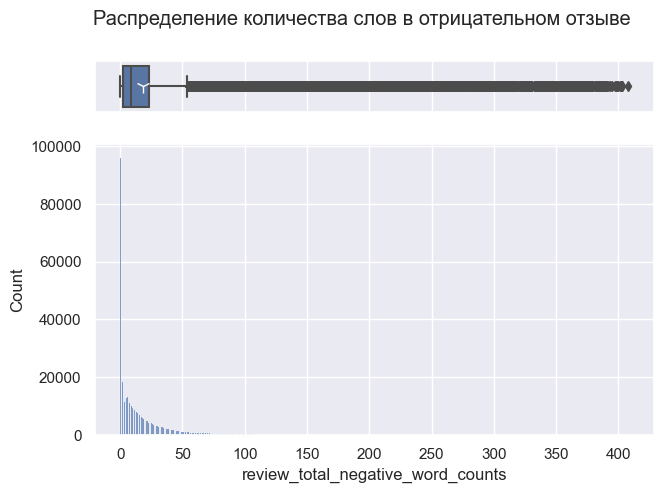

In [22]:
display(hotels['review_total_negative_word_counts'].describe())
box_hist_plot(hotels, 'review_total_negative_word_counts', 'Распределение количества слов в отрицательном отзыве')

count    386803.000000
mean         17.776985
std          21.726141
min           0.000000
25%           5.000000
50%          11.000000
75%          22.000000
max         395.000000
Name: review_total_positive_word_counts, dtype: float64

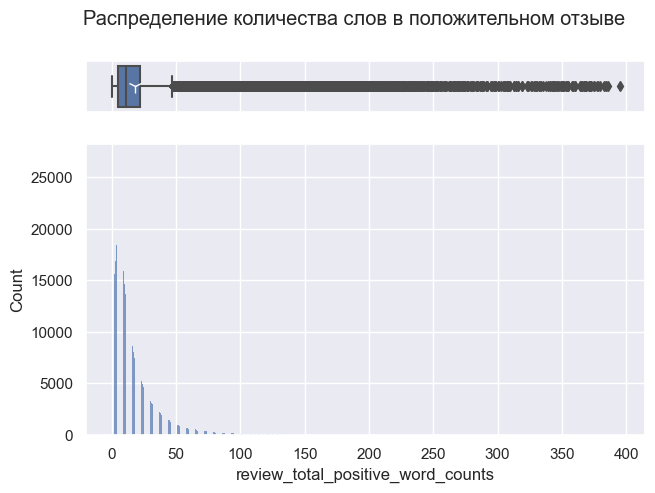

In [23]:
display(hotels['review_total_positive_word_counts'].describe())
box_hist_plot(hotels, 'review_total_positive_word_counts', 'Распределение количества слов в положительном отзыве')

**Note:**
- Позитивные и негативные отзывы могут содержать до нескольких сот слов. При этом медианное количество слов порядка 10.
- Необходимо проверить, влияет ли количество слов больше 20 на оценку.
- При отсутствии слов можно отнести к категориям, выделенным выше по отзывам: no_positive, no_negative 

#### TARGET: **reviewer_score**

count    386803.000000
mean          8.396906
std           1.636090
min           2.500000
25%           7.500000
50%           8.800000
75%           9.600000
max          10.000000
Name: reviewer_score, dtype: float64

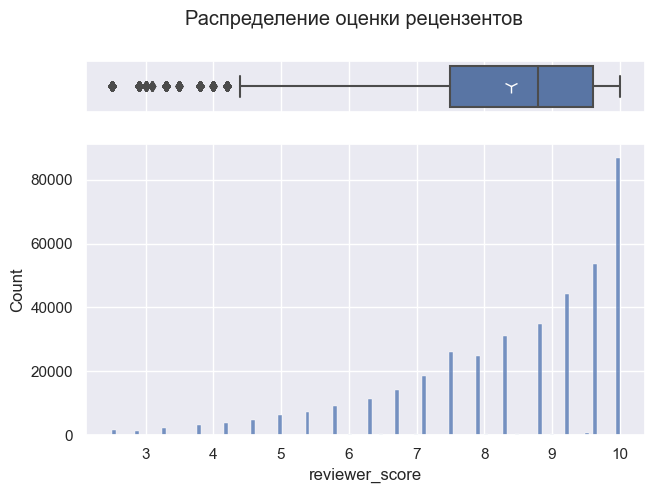

In [40]:
display(hotels['reviewer_score'].describe())
box_hist_plot(hotels, 'reviewer_score', 'Распределение оценки рецензентов')

На данном этапе не будем избавляться от аномальных значений целевого признкака.

#### **total_number_of_reviews_reviewer_has_given**

count    386803.00000
mean          7.17725
std          11.05442
min           1.00000
25%           1.00000
50%           3.00000
75%           8.00000
max         355.00000
Name: total_number_of_reviews_reviewer_has_given, dtype: float64

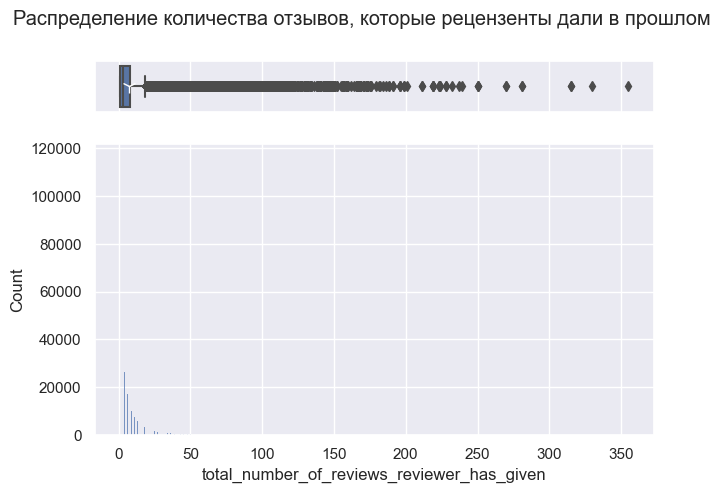

In [26]:
display(hotels['total_number_of_reviews_reviewer_has_given'].describe())
box_hist_plot(hotels, 'total_number_of_reviews_reviewer_has_given', 'Распределение количества отзывов, которые рецензенты дали в прошлом')

Оценим зависимость оценки рецензента от количества данных отзывов.

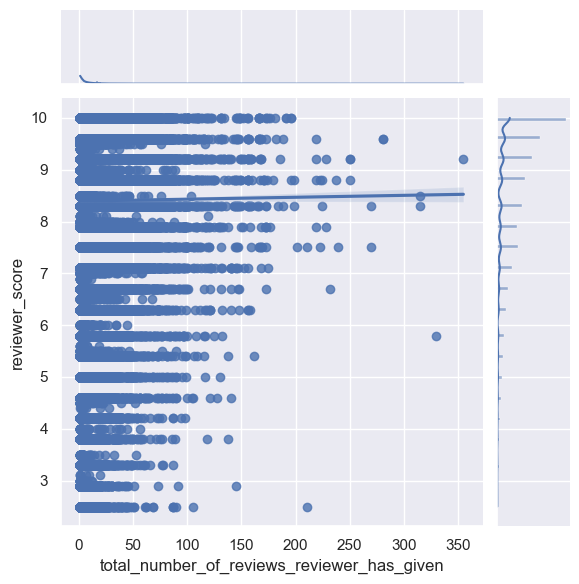

In [35]:
sns.jointplot(y='reviewer_score', x='total_number_of_reviews_reviewer_has_given', data=hotels, kind='reg')

**Note:**
- Возможно, есть положительная корреляция между количеством отзывов, что рецензент давал ранее и рейтингом, им оставленным
- Порядка четверти рецензентов оставляли единственный отзывов, и 3/4 рецензентов оставляли 8 и менее отзывов
- Возможно, имеет смысл ввести порядковый категориальный признак - один, несколько, много отзывов.

#### **total_number_of_reviews**

Рассмотрим, как соотносится количество действительных отзывов отеля с количеством отзывов, представленных в датасете. Соотнесём количество отзывов с количеством оценок без отзывов

In [72]:
# Сгруппируем отели и рассмотрим количество отзывов, и количество оценок без отзывов
hotels_number_of_reviews = hotels.groupby(by=['hotel_name', 'hotel_address']).agg({
    'total_number_of_reviews': ['median','count'],
    'additional_number_of_scoring': 'median'
    })
hotels_number_of_reviews.columns = ['_'.join(col) for col in hotels_number_of_reviews.columns]

# Переименуем колонки
hotels_number_of_reviews = hotels_number_of_reviews.rename(columns={
    'total_number_of_reviews_count': 'row-reviews count', 
    'total_number_of_reviews_median': 'total_number_of_reviews',
    'additional_number_of_scoring_median': 'additional_number_of_scoring'})

# Выделим процентные характеристики количества отзывов и оценок без отзывов
hotels_number_of_reviews['reviews_percentage_ratio'] = hotels_number_of_reviews['row-reviews count']\
    /hotels_number_of_reviews['total_number_of_reviews']*100
hotels_number_of_reviews['additional_percentage_ratio'] =\
    hotels_number_of_reviews['additional_number_of_scoring']\
    /hotels_number_of_reviews['total_number_of_reviews']*100
    
print('Процентное соотношение отзывов, представленных в датафрейме, а также количества оценок без отзыва к общему количеству отзывов')
display(hotels_number_of_reviews[['reviews_percentage_ratio', 'additional_percentage_ratio']].\
    describe())

Процентное соотношение отзывов, представленных в датафрейме, а также количества оценок без отзыва к общему количеству отзывов


,reviews_percentage_ratio,additional_percentage_ratio
count,1494.000000,1494.000000
mean,19.689803,14.773121
std,9.277361,7.244809
min,3.381643,2.040816
25%,12.829634,9.170629
50%,17.126554,12.881135
75%,26.308422,19.352924
max,55.944056,39.705882


**Note**:
- Таким образом, выгрузка отзывов не пропорциональна общему количеству отзывов у всех отелей.
- Оценки без отзывов составляют малую часть общего количества оценок с отзывами. Возможно их соотношение влияет на предсказываемую оценку отеля, что дополнительно можно проверить.

#### **days_since_review**

Количество дней между оставлением отзыва и датой выгрузки. Приведём к числовому формату

In [91]:
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split(' ')[0]))
hotels['days_since_review']

0         531
1         203
2         289
3         681
4         516
         ... 
386798    106
386799    171
386800    543
386801     74
386802    363
Name: days_since_review, Length: 386803, dtype: int64

count    386803.000000
mean        354.387978
std         208.975174
min           0.000000
25%         175.000000
50%         353.000000
75%         527.000000
max         730.000000
Name: days_since_review, dtype: float64

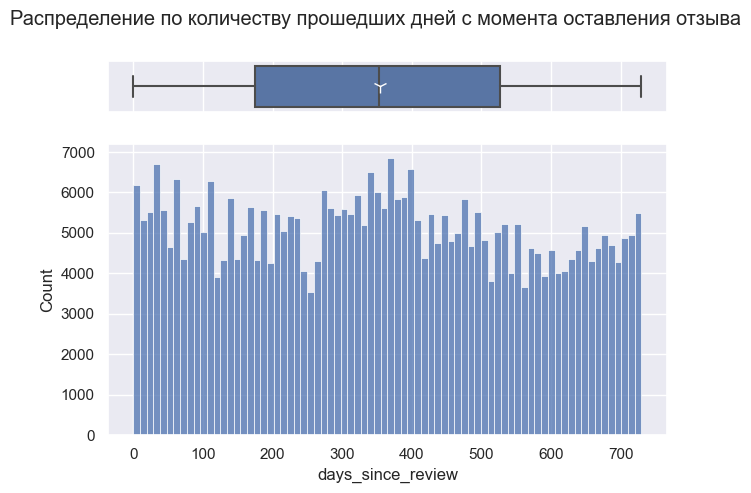

In [95]:
display(hotels['days_since_review'].describe())
box_hist_plot(data=hotels, x='days_since_review', title='Распределение по количеству прошедших дней с момента оставления отзыва')

Проверим влияние количества дней с момента отправки отзыва на рейтинг

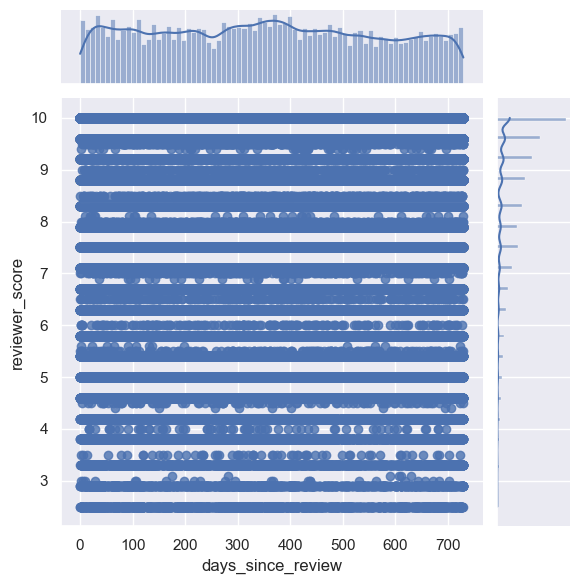

In [96]:
sns.jointplot(y='reviewer_score', x='days_since_review', data=hotels, kind='reg')

**Note:**
- Отзывы примерно равномерно распределены по количеству дней с момента отправки
- Отсутствует графическая взаимосвязь количества дней с момента отправки отзыва и выставленного рейтинга

#### **lat** и **lng**

Эти колонки содержат явные пропуски

In [106]:
lat_nans = hotels['lat'].isna().sum()/hotels.shape[0]*100
lng_nans = hotels['lng'].isna().sum()/hotels.shape[0]*100
print(f'Доля пропусков широты {round(lat_nans,2)}%, долготы {round(lng_nans,2)}%')

Доля пропусков широты 0.63%, долготы 0.63%


**Note:**
- Имеющийся набор данных можно расширить координатами центров городов и соотнести с городами, извлекаемыми из адреса
- Исходя из координат центра города, а также широты и долготы расположения отеля, можно извлечь расстояние от отеля до центра города
- Пропуски в координатах отелей можно заполнить медианным значением расстояния от центра до отеля

### Посмотрим на взаимосвязь числовых признаков

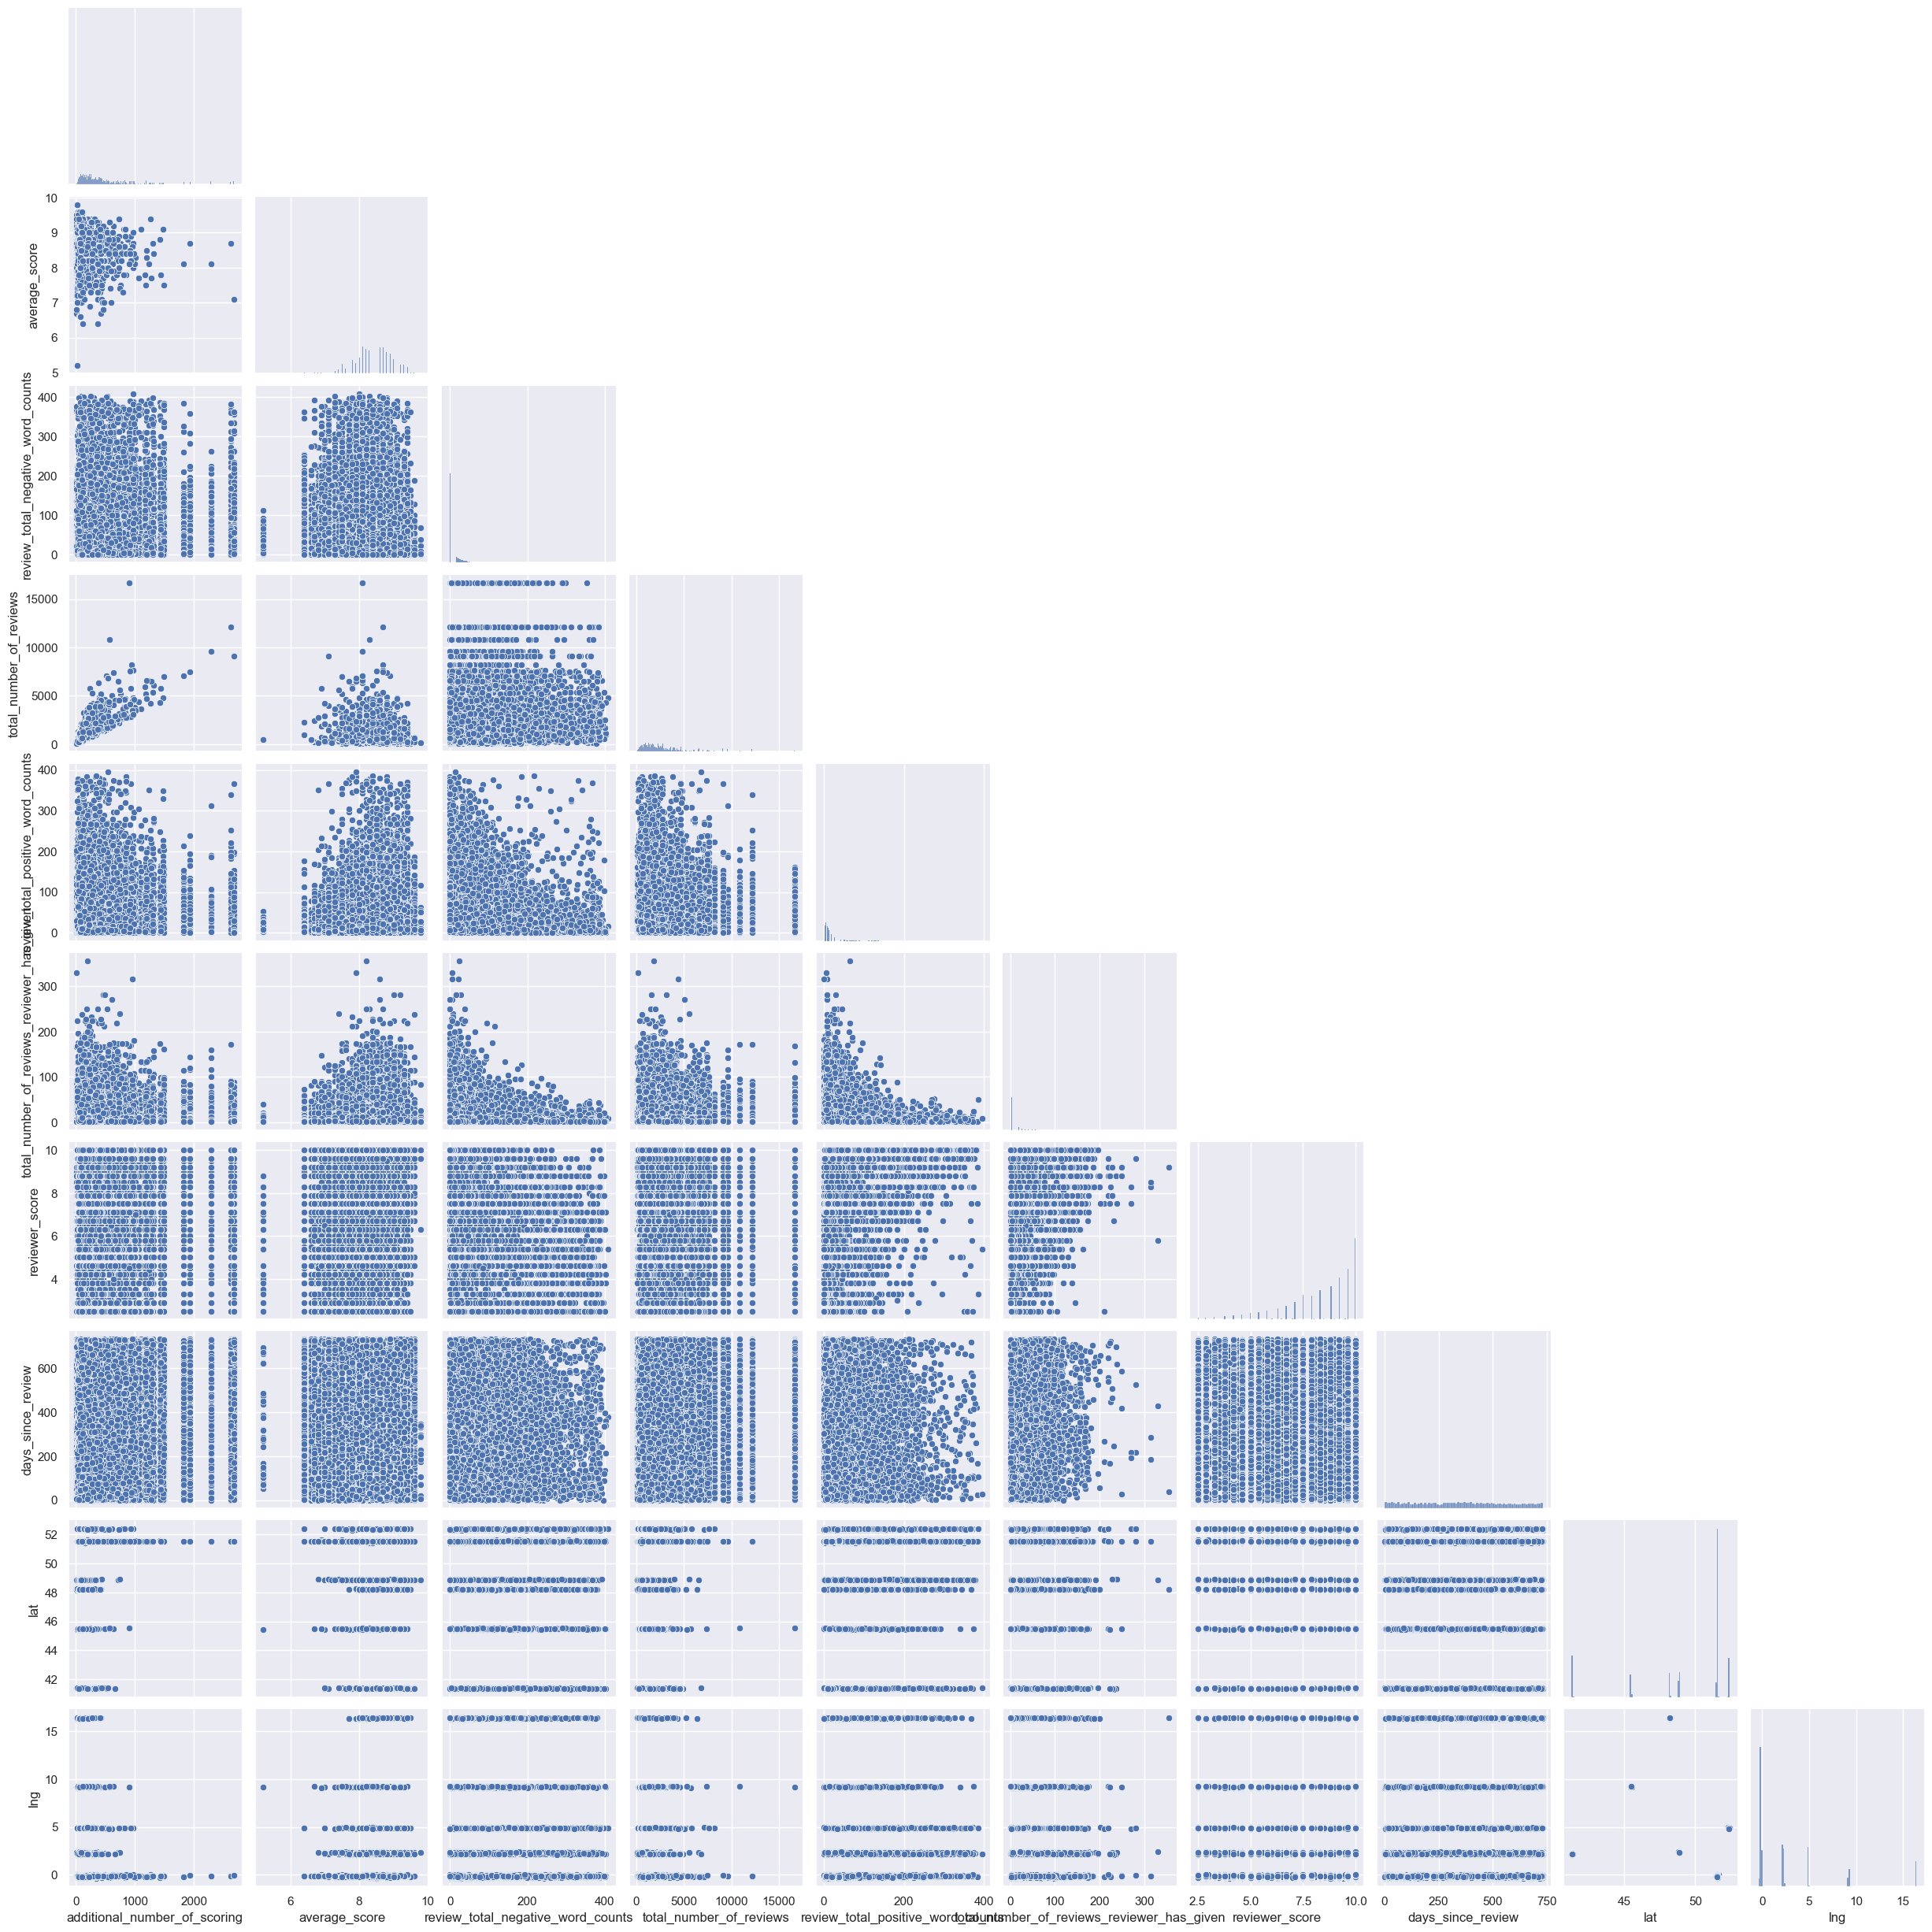

In [108]:
sns.pairplot(hotels, corner=True)

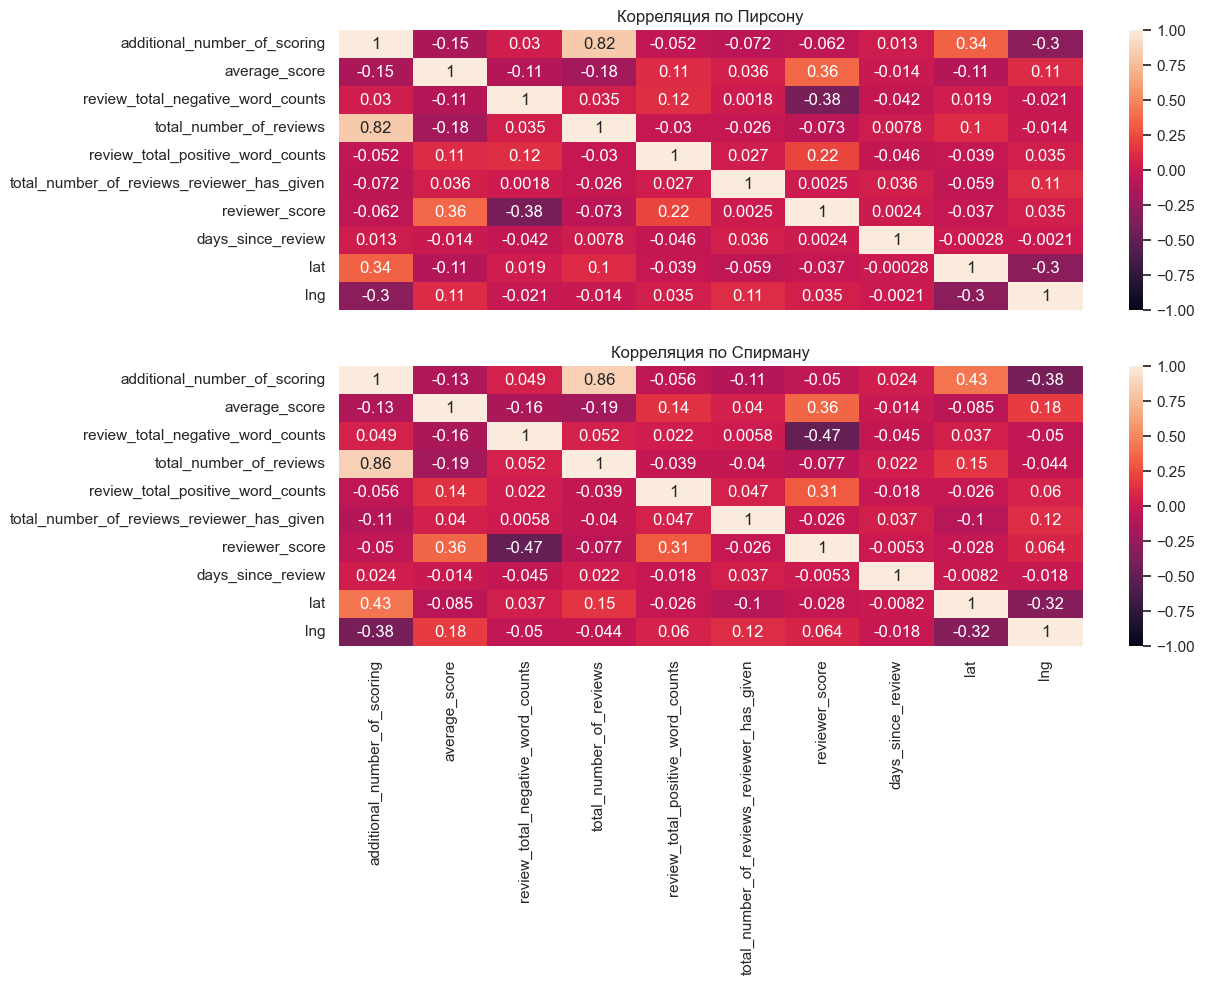

In [133]:
# Убираем предупреждения
import warnings
warnings.filterwarnings("ignore")

# Строим корреляционные графики
fig, (pearson_axes, spearmen_axes) = plt.subplots(2,1, figsize=(12,8));
sns.heatmap(hotels.corr(), vmin=-1, vmax=1, annot=True, ax=pearson_axes);
sns.heatmap(hotels.corr(method='spearman'), vmin=-1, vmax=1, annot=True, ax=spearmen_axes);
# Настраиваем графики
pearson_axes.set_title('Корреляция по Пирсону');
pearson_axes.set_xticks([])
spearmen_axes.set_title('Корреляция по Спирману');

**Correlation Notes:**
- Наблюдается сильная скоррелированность 'total_number_of_reviews' и 'additional_number_of_scoring'. При этом связь обоих параметров с 'review_score' почти отсутствует.
- Наблюдается обратная взаимосвязь 'total_positive_words_count' и 'total_negative_words_count'. Возможно, имеет смысл ввести соотношение количества слов позитивного/негативного отзывов.
- С увеличением количества отзывов, которые оставил рецензент нелинейно уменьшается количество слов в каждом отзыве.
- Наблюдается прямая связь количества слов в положительном отзыве к выставленной оценке и обратная связь количества слов в отрицательном отзыве к выставленной оценке
- Средняя оценка отеля и оценка в отзыве также скоррелированы
- Неожиданно наблюдать корреляцию широты (прямая) и долготы (обратная) расположения отеля и количества оценок без отзывов. Имеет смысл проанализировать детальнее эту взаимосвязь.

## 3. Подготовка данных

### 3.1 Очистка данных
Проводится: 
- удаление/разметка дубликатов;
- заполнение пропусков (при необходимости);
- удаление/разметка выбросов и аномалий

### 3.2 Разведывательный анализ данных (EDA)

Как правило, **включает в себя**:
- Проектирование признаков (Feature Engineering);
- Кодирование признаков (Ordered-, OneHot-, Binary- encoding);
- Проверка статистических гипотез;
- Отбор признаков (Feature Selection)

**Решение-заглушка:**

In [6]:
# убираем признаки, которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберем их и удалим
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)

# заполняем пропуски самым простым способом
hotels = hotels.fillna(0)

## 4. ML-Моделирование

**ОСНОВНЫЕ ЭТАПЫ:**
1. **Разделение набора данных:**
    - "по столбцам":
        - Признаки для обучения модели - **X**
        - Целевая переменная, которую будем предсказывать - **y**
    - "по строкам":
        - Тренировочный набор (**train**), для обучения модели
        - Тестовый набор (**test**), для оценки точности модели
2. **Создание; обучение модели и предсказание значений**
3. **Оценка качества модели**
    - с помощью метрик проверяется точность прогнозов, сделанных моделью.

### 4.1. Разделение набора данных

In [7]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х — данные с информацией об отелях, у — целевая переменная (рейтинги отелей)  
X = hotels.drop([TARGET_NAME], axis=1)
y = hotels[TARGET_NAME]

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" — для тестирования.
# Для тестирования мы будем использовать 25 % от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

### 4.2. Создание и обучение модели

Примечание: 
- для корректной работы все данные в датафрейме, который используется при обучении модели, должны быть в числовых форматах int или float;
- в столбцах не должно быть пропущенных значений. Вместо каждого пропущенного значения вам нужно будет вычислить и поместить в ячейку максимально близкое к реальности значение.

In [8]:
# Создаём модель 
regr = RandomForestRegressor(n_estimators=N_ESTIMATORS)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred 
y_pred = regr.predict(X_test)

### 4.3. Оценка качества модели

In [9]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
train_mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
print('MAPE:', train_mape)
# Запишем показатели метрики
metrics = {
    'train_mape': train_mape
}
experiment.log_metrics(metrics)

MAPE: 0.14137276548008906


### Завершение эксперимента

In [18]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/mvulf/booking-reviews/ad4ee937797e427b887b884803a7bd7c
COMET INFO:   Parameters:
COMET INFO:     n_estimators : 100
COMET INFO:     random_state : 42
COMET INFO:     target_name  : reviewer_score
COMET INFO:     test_size    : 0.25
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (4.98 KB)
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     source_code                  : 1
C

## *5. Валидация*
Должна проводиться проверка того, что построенная модель решает поставленные бизнес задачи; что нет проблем бизнеса, которые не были рассмотрены.

На вход поступает уже построенная модель с высокой используемой метрикой, полученной на шаге моделирования.